# *PageRank* et ses différentes approches (parallélisées)

Kim Antunez, Isabelle Bernard pour le projet d'*Elements Logiciels pour le Traitement de Données Massives* (2020-2021)


## Introduction 

*PageRank* est un algorithme, parmi d'autres, qui mesure la popularité d'une page web. Il fonctionne en classant les pages du Web en fonction de leur popularité (voir description détaillée en partie 1.2).

Il a été inventé par Larry Page [1], cofondateur de Google, et est utilisé par le moteur de recherche de l'entreprise. Il s'agit d'une marque déposée dont le premier brevet a été déposé en 1997. Jusqu'en 2016, les internautes pouvaient obtenir une approximation du classement de chaque page mais depuis, Google ne fournit plus cette valeur. 

###  Principe du *PageRank*


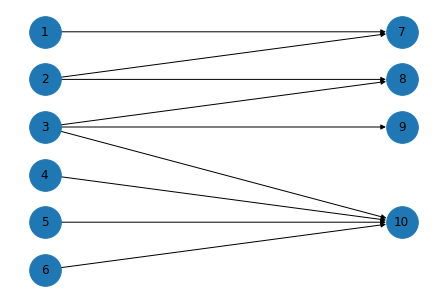

In [36]:
import networkx as nx
import matplotlib.pyplot as plt
G = nx.DiGraph()
G.add_node(1,pos=(1,7))
G.add_node(2,pos=(1,6))
G.add_node(3,pos=(1,5))
G.add_node(4,pos=(1,4))
G.add_node(5,pos=(1,3))
G.add_node(6,pos=(1,2))
G.add_node(7,pos=(2,7))
G.add_node(8,pos=(2,6))
G.add_node(9,pos=(2,5))
G.add_node(10,pos=(2,3))
G.add_edges_from([(1, 7), (2, 7),(2, 8),(3, 8),(3, 9),(3, 10),(4, 10),(5, 10),(6, 10)])
nx.draw(G, nx.get_node_attributes(G,'pos'), with_labels=True, node_size=1000)
plt.show()

La modélisation adoptée utilise la théorie des graphes. Le web est un **graphe orienté** $G$ contient $N$ **noeuds** (pages, ici $N = 10$) reliés par des **liens** orientés (hyperliens). Un **degré entrant** (*in-degree*) d'une page correspond aux nombre d'hyperliens qui pointent sur elle et le **degré sortant** (*out-degree*) le nombre d'hyperliens vers lesquels elle pointe. 

Si l'on veut faire une première vulgarisation de l'algorithme, on peut dire que *PageRank* cherche à respecter les propriétés suivantes : 


1. **Popularité absolue** : plus le nombre de pages citant une page est grande, plus sa popularité doit être élevée. 

*Exemple : Dans la figure qui suit, le noeud $10$ est particulièrement populaire car 4 noeuds (les $3$, $4$, $5$ et $6$) pointent vers lui.*

2. **Popularité relative** : quand deux pages sont citées le même nombre de fois, c'est la page qui a été le plus cité en proportion par ses voisins qui doit être la plus populaire. 

*Exemple : On cherche à distinguer la popularité des noeuds $7$ et $8$ qui ont chacun deux noeuds qui pointent vers eux. On considère que le noeud $7$ est plus populaire car le noeud $1$ popularise exclusivement ce noeud, alors que le noeud $3$ popularise le noeud $8$ dans une moindre mesure car il popularise 2 autres noeuds ($9$ et $10$).* 

=> *PageRank* se rapproche d'une mesure de centralité sur le réseau du web. **Plus la page web a de chance d'être dans les premières positions lors d'une recherche sur internet, plus le *PageRank* sera élevé**. Son principe est d'attribuer à chaque page un score proportionnel au nombre de fois que passerait par cette page un utilisateur parcourant le graphe du Web en cliquant aléatoirement, sur un des liens apparaissant sur chaque page. Une page a un *PageRank* d'autant plus important qu'est grande la somme des *PageRanks* des pages qui pointent vers elle. 

La très grande taille de ce graphe et son évolution rendent coûteuses en opérations le calcul d'un *PageRank* pour une nouvelle page. C'est pourquoi des algorithmes d'approximation.

### Algorithme de Page Rank



<mark> Cette partie n'est pas rédigée </mark>

Mathématiquement, pour un noeud $q$, on note $r(q)$ le rang de la page $q$ et $d(q)$ le nombre de noeuds auxquels il fait référence (degré sortant). Pour obtenir le rang d'une page $p$ il faut sommer le ratio de ces deux quantités sur l'ensemble des noeuds $q$ voisins de $p$ ($q \rightarrow p$).


\begin{equation}
r(p)=\sum_{ q \rightarrow p}\frac{r(q)}{d(q)}
\end{equation}


https://www.geeksforgeeks.org/page-rank-algorithm-implementation/

PageRank value for a page u is dependent on the PageRank values for each page v contained in the set Bu (the set containing all pages linking to page u), divided by the number L(v) of links from page v. The algorithm involves a damping factor for the calculation of the pagerank. It is like the income tax which the govt extracts from one despite paying him itself.

 The eigenvector calculation is done by the power iteration method 
    and has no guarantee of convergence.  The iteration will stop 
    after max_iter iterations or an error tolerance of 
    number_of_nodes(G)*tol has been reached. 
  
 The PageRank algorithm was designed for directed graphs but this 
    algorithm does not check if the input graph is directed and will 
    execute on undirected graphs by converting each edge in the 
    directed graph to two edges. 
  
  By default, dangling nodes (without any outwedges) are given 
      outedges according to the personalization vector (uniform if not 
      specified). This must be selected to result in an irreducible transition 
      matrix (see notes under google_matrix). It may be common to have the 
      dangling dict to be the same as the personalization dict. 

### Approximation de Monte-Carlo

Cette approximation de Monte-Carlo de l'algorithme *PageRank* s'appuie sur l'article [4]. 

Une première approximation du PageRank de chaque site web peut être réalisée par une méthode de Monte Carlo simple à appréhender et à vulgariser. 

Il s’agit de simuler le comportement d’un utilisateur sur le web qui navigue de page en page. Et à chaque fois que l’utilisateur tombe sur une page donnée, il gagne un point.

1.	Tout d’abord, l’utilisateur tombe (au hasard) sur une des $N$ pages web...
2.	Il suit aléatoirement un lien présent sur cette page...
3.	Puis il continue de suivre aléatoirement un lien sur la page suivante...
4.	Et ainsi de suite jusqu’à la fin des itérations...
5.	On rapporte le nombre de visite de chaque site au nombre total de sites visités. 

On répète le processus de nombreuses fois et on suppose que l’algorithme s’arrête sous certaines conditions (dans une proportion $1-\alpha$ le processus repart sur un nœud aléatoire pour ne pas resté coincer dans un sous-ensemble de nœuds déconnectés du reste du réseau)

A la fin, c’est la page qui a le plus de points qui est considérée comme étant la plus populaire du réseau. Chaque simulation donnera des résultats différents mais il a été prouvé mathématiquement que l’algorithme converge. C’est bien une approximation de l’algorithme de *PageRank*. 

###  Approximation locale de *PageRank*

Cette approximation locale de l'algorithme *PageRank* s'appuie sur l'article [2]. 

Il s'agit d'approximer le vecteur des rangs de l'ensemble des pages en faisant un calcul itératif (marche aléatoire). Après avoir initialisé un rang de $\frac{1}{N}$ pour toutes les pages, on met à jour le vecteur de rangs de la manière suivante où $i$ correspond au numéro de l'itération : 

$$r^{i+1}(p)=\sum_{ q \rightarrow p}\frac{r^{i}(q)}{d(q)}$$

Cependant, dans cette formulation, si un noeud $p$ n'a pas de degré sortant $q$, c'est-à-dire qu'il ne fait référence à aucune page, son rang n'est pas mis à jour dans l'algorithme à l'itération suivante, ce qui entraîne une perte de la valeur totale du *PageRank*. Une solution serait de nettoyer itérativement le graphe en enlevant les pages sans hyperliens. Mais, même en procédant ainsi, le graphe peut toujours contenir des groupes de pages très peu connectés entre eux qui posent le même problème. C'est pourquoi on introduit un facteur d'amortissement $\alpha$ (par exemple $\alpha = 0,85$), et avec une probabilité $\alpha$ on réalise l'algorithme précédent (c'est-à-dire on choisit aléatoirement un degré sortant du noeud considéré) et avec la probabilité $1-\alpha$, on choisit un noeud au hasard : 

$$r^{i+1}(p)=\frac{1-\alpha}{N}+\alpha \sum_{ q \rightarrow p}\frac{r^{i}(q)}{d(q)}$$

Cet algorithme converge si le taux d'évolution du rang du noeud entre 2 itérations est petit et inférieur à un certain seuil $\varepsilon$ : 


$$\left | \frac{r^{i}(p) - r^{i-1}(p)}{r^{i-1}(p)} \right | < \varepsilon$$


## Application


In [37]:
from pyspark import SparkContext
import numpy as np
import pandas as pd
import random
import networkx as nx
import matplotlib.pyplot as plt

### Fonctions utiles

In [256]:
def pagerank(G, alpha=0.85, max_iter=100, tol=1.0e-6): 
  
    """Retourne : un dictionnaire de noeuds dont les valeurs correspondent aux PageRank     
  
    Paramètres
    ---------- 
    -G : graph (de type NetworkX) 
    -alpha : paramètre d'amortissement (0,85 par défaut) 
    -max_iter : nombre maximum d'itération dans la recherche de valeurs propres. 
    -tol : erreur de tolérence acceptée pour la convergence de la méthode de recherche des valeurs propres. 
     
    """
    # Créer une copie sous forme de graphique droit-stochastique (pour chaque noeud, la somme des poids des liens sortant vaut 1)    
    W = nx.stochastic_graph(G, weight=None)
    N = W.number_of_nodes() 
  
    # Initialisation à 1/N 
    x = dict.fromkeys(W, 1.0 / N) 
    p = dict.fromkeys(W, 1.0 / N)
    dangling_weights = x 
    dangling_nodes = [n for n in W if W.out_degree(n, weight=None) == 0.0] 
    
    for _ in range(max_iter): 
        xlast = x 
        x = dict.fromkeys(xlast.keys(), 0)
        danglesum = alpha * sum(xlast[n] for n in dangling_nodes) 
        for n in x: 
  
            # multiplication à gauche x^T=xlast^T*W 
            for nbr in W[n]: 
                x[nbr] += alpha * xlast[n] * W[n][nbr][None] 
            x[n] += danglesum * dangling_weights[n] + (1.0 - alpha) * p[n] 
          
        # vérifier la convergence L1
        err = sum([abs(x[n] - xlast[n]) for n in x]) 
        if err < N*tol: 
            return x
    raise NetworkXError('pagerank: erreur de convergence au bout '
                        'de %d iterations.' % max_iter) 

In [257]:
def pagerank_montecarlo(G, alpha=0.85, max_iter=100):
    
    """Retourne : un dictionnaire de noeuds dont les valeurs correspondent aux PageRank     
  
    Paramètres
    ---------- 
    -G : graph (de type NetworkX) 
    -alpha : paramètre d'amortissement (0,85 par défaut) 
    -max_iter : nombre maximum d'itération dans la recherche de valeurs propres. 
     
    """

    noeuds=list(G.nodes())

    i=0
    pages_visitees_par_noeud = dict.fromkeys(noeuds, 0) 

    while i < max_iter:
        noeud = random.choice(noeuds)
        while random.random() < alpha:
            pages_visitees_par_noeud[noeud] = pages_visitees_par_noeud[noeud] + 1
            noeud = random.choice(list(G.successors(noeud)))
        i = i + 1
        
    pages_visitees_total = sum(pages_visitees_par_noeud.values())
    pages_visitees_par_noeud = {k: v / pages_visitees_total for k, v in pages_visitees_par_noeud.items()}
    return pages_visitees_par_noeud, pages_visitees_total


### Petites données fictives

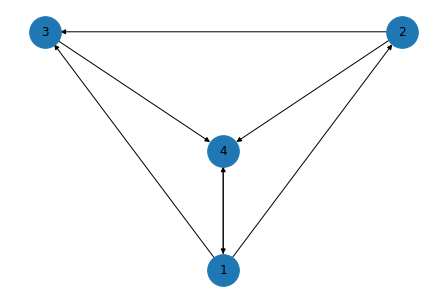

In [169]:
G1 = nx.DiGraph()
G1.add_node(1,pos=(2,1))
G1.add_node(2,pos=(3,3))
G1.add_node(3,pos=(1,3))
G1.add_node(4,pos=(2,2))
liens = [(1, 2), (1, 3),(1, 4),(2, 3),(2, 4),(3, 4),(4, 1)]
G1.add_edges_from(liens)
nx.draw(G1, nx.get_node_attributes(G1,'pos'), with_labels=True, node_size=1000)
plt.show()

**PageRank classique**

In [258]:
print(pagerank(G1,max_iter=10000))

{1: 0.3328665861942923, 2: 0.13181238930543057, 3: 0.1878321232402152, 4: 0.3474889012600618}


**Approximation de Monte-Carlo**

In [254]:
print(pagerank_montecarlo(G1,max_iter=10000))

({1: 0.33377135348226017, 2: 0.1305060032761507, 3: 0.1881626554821522, 4: 0.3475599877594369}, 55553)


+560000 sites web ont été visité en tout. Le site web 1 a été visité 33 % des fois. 

### Données réelles

TODO

## Bibliographie 

[1] S. Brin and L. Page. The anatomy of a large-scalehypertextual web search engine. InProc. of theSeventh World Wide Web Conference, 1998.

[2] Z.Bar-Yossefet L.T.Mashiach. « Local Approximation of PageRank and Reverse Page-Rank ». In :CIKM(oct. 2008).

[3]  Q. GanY. Chenet T.Suel. « Local methods for estimating PageRank values ». In :CIKM(2004), 381–38

[4] Bahmani, B., Chowdhury, A., & Goel, A. (2010). Fast incremental and personalized pagerank. arXiv preprint arXiv:1006.2880.

http://www.economiematin.fr/news-algorythme-page-rank-popularite-web

## Brouillon Kim à suppr

#N=len(G1)
#df=pd.DataFrame(liens,columns=['entrant','sortant'])
